In [0]:
# Import TensorFlow and enable eager execution
# This code requires TensorFlow version >=1.9
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [0]:
!unzip memes.zip

In [0]:
PATH = os.path.abspath(".")
image_Path = PATH + "/memes/"

In [0]:
with open(PATH+"/annotations.pkl", "rb") as f:
  annotations = pickle.load(f)

In [0]:
all_captions = []
all_img_name_vector = []
maxlen = 0
for annot in annotations:
  caption = '<start> ' + annot['caption'] + ' <end>'
  if len(annot['caption']) > maxlen:
    maxlen = len(annot['caption'])
  image_id = annot['image_id']
  full_coco_image_path = image_Path + image_id
  if os.path.isfile(full_coco_image_path) and len(annot['caption'])>2:
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state = 1)

In [0]:
sample = 50000
train_captions = train_captions[:sample]
img_name_vector = img_name_vector[:sample]

In [0]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
top_k = 15000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+,-./:;= ?@[\\]^_`{|}~\t\n'
                                                  
                                                 )

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_length = calc_max_length(train_seqs)

In [0]:
cap_vector.shape
  

In [0]:
indices=[]

In [0]:
for j in range(len(cap_vector)):
  real_caption = [tokenizer.index_word[i] for i in cap_vector[j] if i not in [0]]
  num_unk = real_caption.count('<unk>')
  if num_unk >= 2:
    indices.append(j)

In [0]:
len(indices),len(cap_vector),len(img_name_vector)

In [0]:
cap_vector = [i for j, i in enumerate(cap_vector) if j not in indices]
img_name_vector = [i for j, i in enumerate(img_name_vector) if j not in indices]

In [0]:
len(cap_vector),len(img_name_vector)

In [0]:
len(tokenizer.word_index)+1

In [0]:
def load_image(image_path):
  img = tf.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)#color
  img = tf.image.resize_images(img, (299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top = False,
                                               weights = 'imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [0]:
encode_train = sorted(set(img_name_vector))


image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [0]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


In [0]:
img_name_train,img_name_val,cap_train,cap_val = train_test_split(img_name_vector,
                                                                cap_vector,
                                                                test_size=0.2,
                                                                random_state=0)

In [0]:
len(img_name_train),len(img_name_val),len(cap_train), len(cap_val)

In [0]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)+1
# vocab_size = 20000
print(vocab_size)
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [0]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.py_func(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units,
                              return_sequences=True,
                              return_state=True,
                              recurrent_activation='sigmoid',
                              recurrent_initializer='glorot_uniform')
  

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis = 1)
    return context_vector, attention_weights


In [0]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    
    self.fc = tf.keras.layers.Dense(embedding_dim)
    
  def call(self,x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
    
  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    
    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector,1),x], axis = -1)
    
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)
    
    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = tf.keras.losses.sparse_categorical_crossentropy(real, pred,from_logits=True)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

optimizer = tf.train.AdamOptimizer()

In [0]:
loss_plot = []

In [0]:
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [0]:
start_epoch = 0
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
#     ckpt_manager.save()

In [0]:
max_length=20 #max length of caption

In [0]:
max_length=20
def evaluate(image):
  attention_plot = np.zeros((max_length, attention_features_shape))
  
  hidden = decoder.reset_state(batch_size=1)
  
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  features = encoder(img_tensor_val)
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []
  
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])
    
    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot
    dec_input = tf.expand_dims([predicted_id], 0)
    
  attention_plot = attention_plot[:len(result),:]
  return result, attention_plot

In [0]:
def reevaluate(image):
  hidden = decoder.reset_state(batch_size=1)
  
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  features = encoder(img_tensor_val)
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []
  max_length=20
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
      return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

In [0]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))
  
  fig = plt.figure(figsize=(10,10))
  
  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8,8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
  plt.tight_layout()
  plt.show()

In [0]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = [tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]
result, attention_plot = evaluate(image)

print('Real Caption:', ' '.join(real_caption[1:-1]))
print('Predicted Caption:', ' '.join(result[:-1]))
# plot_attention(image,result,attention_plot)
print(image)
Image.open(img_name_val[rid])

In [0]:
res = []
real = []
for j in range(len(img_name_val)):
  image = img_name_val[j]
#   real_caption = [tokenizer.index_word[i] for i in cap_val[j] if i not in [0]]
  result = reevaluate(image)
  res.append(result[:-1])
  real.append(image)
  if j % 100 == 0:
    print(j)



In [0]:
len(res)

In [0]:
d_file = open('/content/result.pkl', 'wb')
pickle.dump(res, d_file)
d_file.close()

f_file = open('/content/reals.pkl', 'wb')
pickle.dump(real, f_file)
f_file.close()


from google.colab import files
files.download('/content/result.pkl')

In [0]:
from google.colab import files
files.download('/content/reals.pkl')

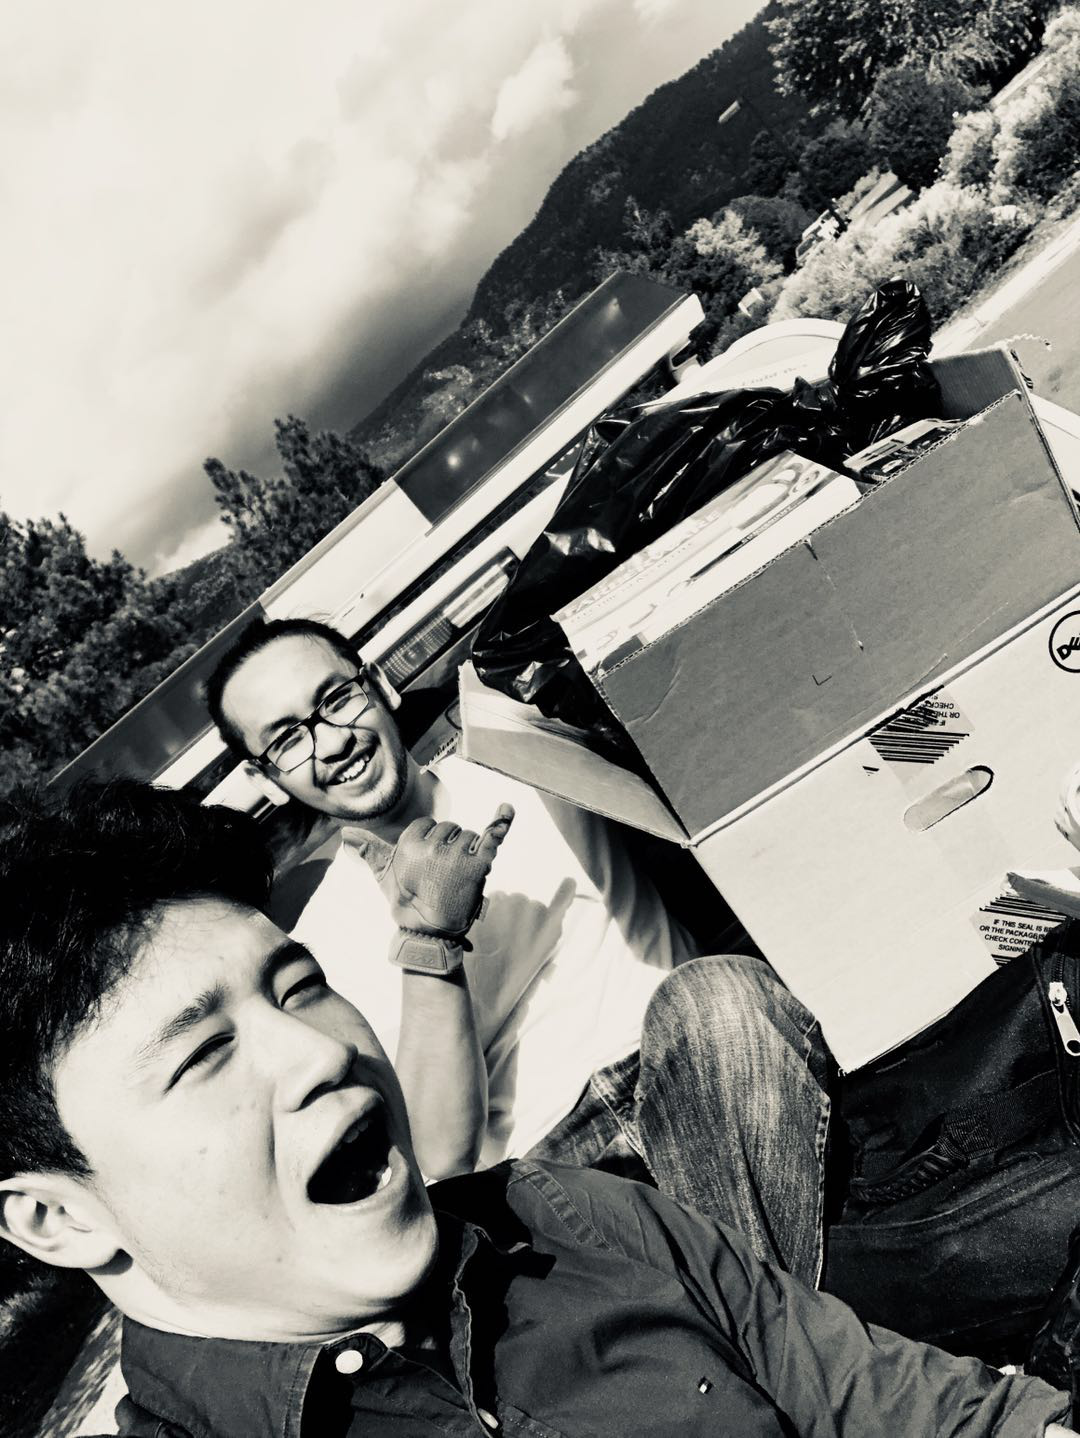

In [0]:
image = '/content/alex.jpg' #own meme

Image.open(image)

In [0]:
result, attention_plot = evaluate(image)
print('Predicted Caption:', ' '.join(result[:-1]))